Exam_prep

Problem 1

1. Using the data in “problem1.csv”

<ol type="a">
  <li>Calculate Log Returns (2pts)</li>
  <li>Calculate Pairwise Covariance (4pt)</li>
  <li>Is this Matrix PSD? If not, fix it with the “near_psd” method (2pt)</li>
  <li>Discuss when you might see data like this in the real world. (2pt)</li>
</ol>



In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [172]:
problem1 = pd.read_csv('problem1.csv')
problem1.head()

,Price1,Price2,Price3,Date
0,87.702209,108.578277,126.052618,2023-11-26
1,89.958023,106.879040,128.348321,2023-11-27
2,89.108885,104.930588,127.324218,2023-11-28
3,88.403296,NaN,NaN,2023-11-29
4,89.692499,111.047562,128.013536,2023-11-30


In [173]:
def return_calculate(prices_df, method="DISCRETE", date_column="Date"):
    vars = prices_df.columns
    n_vars = len(vars)
    vars = [var for var in vars if var != date_column]
    
    if n_vars == len(vars):
        raise ValueError(f"date_column: {date_column} not in DataFrame: {vars}")
    
    n_vars = n_vars - 1
    
    p = prices_df[vars].values
    n = p.shape[0]
    m = p.shape[1]
    p2 = np.empty((n-1, m))
    
    for i in range(n-1):
        for j in range(m):
            p2[i, j] = p[i+1, j] / p[i, j]
    
    if method.upper() == "DISCRETE":
        p2 = p2 - 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError(f"method: {method} must be in (\"LOG\",\"DISCRETE\")")
    
    dates = prices_df[date_column].iloc[1:]
    
    # Create a new DataFrame with all columns
    data = {date_column: dates}
    for i in range(n_vars):
        data[vars[i]] = p2[:, i]
    
    out = pd.DataFrame(data)
    
    return out

returns = return_calculate(problem1, method="LOG", date_column="Date")
print(returns.head())

         Date    Price1    Price2    Price3
1  2023-11-27  0.025396 -0.015774  0.018048
2  2023-11-28 -0.009484 -0.018399 -0.008011
3  2023-11-29 -0.007950       NaN       NaN
4  2023-11-30  0.014478       NaN       NaN
5  2023-12-01 -0.022319 -0.038680 -0.001883


In [174]:
#drop the date column from returns
returns = returns.drop('Date', axis=1)

print(returns.head())

     Price1    Price2    Price3
1  0.025396 -0.015774  0.018048
2 -0.009484 -0.018399 -0.008011
3 -0.007950       NaN       NaN
4  0.014478       NaN       NaN
5 -0.022319 -0.038680 -0.001883


In [ ]:
 # get rid of the missing values

# use the returns without dates to calculate the covariance matrix

In [175]:
def covariance_matrix(input_df, skipna=True):
    # calculate the covariance matrix either pairwise or skipping rows

    if skipna:
        cov_matrix = input_df.dropna().cov()
    else:
        cov_matrix = input_df.cov()

    # Set the column and index names to match the input
    cov_matrix.columns = input_df.columns
    cov_matrix.index = input_df.columns

    return cov_matrix


In [36]:
# problem1_copy = problem1.copy()
# problem1_copy = problem1_copy.dropna()
# problem1_copy = problem1_copy.drop(columns=['Date'])

# problem1_copy.head()

In [7]:
#drop the date

pairwise_cov = covariance_matrix(returns, skipna=True)
print(pairwise_cov)

          Price1    Price2    Price3
Price1  0.000383  0.000088 -0.000025
Price2  0.000088  0.000312 -0.000001
Price3 -0.000025 -0.000001  0.000082


In [8]:
def is_psd(matrix):
    # Check if a matrix is positive semidefinite
    eigenvalues = np.linalg.eigvals(matrix)
    psd =  np.all(eigenvalues >= 0)
    if psd:
        print("The matrix is positive semidefinite.")
    else:
        print("The matrix is not positive semidefinite.")
        # Print the negative eigenvalues
        negative_eigenvalues = eigenvalues[eigenvalues < 0]
        print("Negative Eigenvalues:", negative_eigenvalues)


def near_psd(a, epsilon=0.0):
    n = a.shape[0]

    invSD = None
    out = a.copy()

    # Calculate the correlation matrix if we got a covariance
    if np.sum(np.isclose(np.diag(out), 1.0)) != n:
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = np.dot(np.dot(invSD, out), invSD)

    # SVD, update the eigenvalue and scale
    vals, vecs = np.linalg.eigh(out)

    vals = np.maximum(vals, epsilon)
   
    T = 1.0 / (vecs * vecs @ vals)
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = np.dot(np.dot(T, vecs), l)
    out = np.dot(B, B.T)

    # Add back the variance
    if invSD is not None:
        invSD = np.diag(1.0 / np.diag(invSD))
        out = np.dot(np.dot(invSD, out), invSD)

    return out

def chol_psd(root, a):
    n = a.shape[0]

    # Initialize the root matrix with 0 values
    root.fill(0.0)

    # Loop over columns
    for j in range(n):
        s = 0.0

        # If we are not on the first column, calculate the dot product of the preceding row values.
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])

        # Diagonal Element
        temp = a[j, j] - s
        if 0.0 >= temp >= -1e-8:
            temp = 0.0
        root[j, j] = np.sqrt(temp)

        # Check for the 0 eigenvalue. Just set the column to 0 if we have one
        if root[j, j] == 0.0:
            root[j, j+1:] = 0.0
        else:
            # Update off-diagonal rows of the column
            ir = 1.0 / root[j, j]
            for i in range(j+1, n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i, j] = (a[i, j] - s) * ir
    return root

In [39]:
is_psd(pairwise_cov)

The matrix is positive semidefinite.


d. Discuss when you might see data like this in the real world. (2pt)

Problem 2

2. “problem2.csv” contains data about a call option. Time to maturity is given in days. Assume 255 days in a year.

<ol type="a">
  <li>Calculate the call price (1pt)</li>
  <li>Calculate Delta (1pt)</li>
  <li>Calculate Gamma (1pt)</li>
  <li>Calculate Vega (1pt)</li>
  <li>Calculate Rho (1pt)</li>
 Assume you are long 1 share of underlying and are short 1 call option. Using Monte Carlo assuming a Normal distribution of arithmetic returns where the implied volatility is the annual volatility and 0 mean 
  <li>Calculate VaR at 5% (2pt)</li>
  <li>Calculate ES at 5% (2pt)</li>
  <li>This portfolio’s payoff structure most closely resembles what? (1pt)</li>
</ol>

In [23]:
problem2 = pd.read_csv('problem2.csv')
problem2.head()

,Underlying,Strike,IV,TTM,RF,DivRate
0,104.439125,92.838916,0.17,173,0.045,0.046773


In [10]:
import numpy as np
from scipy.stats import norm

# Given data from the CSV file
underlying = 104.439125
strike = 92.838916
iv = 0.17  # Implied Volatility
ttm_days = 173  # Time to maturity in days
rf = 0.045  # Risk-Free Rate
div_rate = 0.046773  # Dividend Rate

# Convert Time to Maturity from days to years
ttm = ttm_days / 255

# Calculate d1 and d2
d1 = (np.log(underlying / strike) + (rf - div_rate + 0.5 * iv**2) * ttm) / (iv * np.sqrt(ttm))
d2 = d1 - iv * np.sqrt(ttm)

# Calculate Call Price
call_price = (underlying * np.exp(-div_rate * ttm) * norm.cdf(d1)) - (strike * np.exp(-rf * ttm) * norm.cdf(d2))

# Calculate Greeks
delta = np.exp(-div_rate * ttm) * norm.cdf(d1)
gamma = np.exp(-div_rate * ttm) * norm.pdf(d1) / (underlying * iv * np.sqrt(ttm))
vega = underlying * np.exp(-div_rate * ttm) * np.sqrt(ttm) * norm.pdf(d1)
rho = strike * ttm * np.exp(-rf * ttm) * norm.cdf(d2)

# Print results
print(f"Call Price: {call_price}")
print(f"Delta: {delta}")
print(f"Gamma: {gamma}")
print(f"Vega: {vega}")
print(f"Rho: {rho}")


Call Price: 12.64468730412105
Delta: 0.7910386533553834
Gamma: 0.01759086228207317
Vega: 22.129337982595665
Rho: 47.47031633872305


In [13]:
def greeks(underlying_price, strike_price, risk_free_rate, implied_volatility, continuous_dividend_rate, current_date, expiration_date, option_type):
    T = (expiration_date - current_date) / 255
    r = risk_free_rate
    q = continuous_dividend_rate
    b = r - q
    S = underlying_price
    X = strike_price
    sigma = implied_volatility

    d1 = (np.log(S/X)+(b+(0.5*sigma**2))*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    # call_price = (underlying * np.exp(-div_rate * ttm) * norm.cdf(d1)) - (strike * np.exp(-rf * ttm) * norm.cdf(d2))

    if option_type == 'call':
        # Calculate Call Price
        call_price = (underlying * np.exp(-div_rate * ttm) * norm.cdf(d1)) - (strike * np.exp(-rf * ttm) * norm.cdf(d2))
        delta = np.exp((b-r)*T)*norm.cdf(d1)
        theta = -1*(S*np.exp((b-r)*T)*norm.pdf(d1)*sigma)/(0.5*np.sqrt(T)) - (b-r)*S*np.exp((b-r)*T)*norm.cdf(d1) - r*X*np.exp(-r*T)*norm.cdf(d2)
        rho = T*X*np.exp(-r*T)*norm.cdf(d2)
        carry_rho = T*S*np.exp((b-r)*T)*norm.cdf(d2)

    else:
        delta = np.exp((b-r)*T)*(norm.cdf(d1) - 1)
        theta = -1*(S*np.exp((b-r)*T)*norm.pdf(d1)*sigma)/(0.5*np.sqrt(T)) + (b-r)*S*np.exp((b-r)*T)*norm.cdf(-1*d1) + r*X*np.exp(-r*T)*norm.cdf(-1*d2)
        rho = -1*T*X*np.exp(-r*T)*norm.cdf(-d2)
        carry_rho = -1*T*S*np.exp((b-r)*T)*norm.cdf(-d2)

    gamma = norm.pdf(d1)*np.exp((b-r)*T)/(S*sigma*(np.sqrt(T)))
    vega = S*np.exp((b-r)*T)*norm.pdf(d1)*np.sqrt(T)

    return call_price, delta, gamma, vega, theta, rho, carry_rho

In [25]:
underlying = 104.439124578387
strike = 92.8389161823596
iv = 0.17  # Implied Volatility
ttm_days = 173  # Time to maturity in days
rf = 0.045  # Risk-Free Rate
div_rate = 0.0467733483754155  # Dividend Rate

call_price, delta, gamma, vega, theta, rho, carry_rho = greeks(underlying, strike, rf, iv, div_rate, 0, ttm_days, 'call')

# print(greeks)

print(f"Delta: {delta}")
print(f"Gamma: {gamma}")
print(f"Vega: {vega}")
# print(f"Theta: {theta}")
print(f"Rho: {rho}")
# print(f"Carry Rho: {carry_rho}")
print(f"Call Price: {call_price}")

Delta: 0.7910380211549434
Gamma: 0.01759088566580787
Vega: 22.129367220708858
Rho: 47.47028488462286
Call Price: 12.644667307128373


In [ ]:
#for the rho use the the finite difference method

In [15]:
a = greeks(underlying, strike, rf, iv, div_rate, 0, ttm_days, 'call')
print(a[0])

12.64468730412105


In [16]:
# Calculate VaR Normal Distribution: (Value at Risk)
def calc_var_normal(mean, std_dev, alpha=0.05):
    VaR = norm.ppf(alpha, loc=mean, scale=std_dev)

    return -VaR

# Calculte VaR T Distribution: (Value at Risk)
def calc_var_t_dist(mean, std_dev, df, alpha=0.05):
    VaR = t.ppf(q=alpha, df=df, loc=mean, scale=std_dev)

    return -VaR

# Calculate ES for Normal (expected shortfall)
def calc_expected_shortfall_normal(mean, std_dev, alpha=0.05):
    
    # Calculate ES using the formula
    es = -1*mean + (std_dev * norm.pdf(norm.ppf(alpha, mean, std_dev)) / alpha)

    return es

In [18]:
# Calculate options price
def options_price(S, X, T, sigma, r, b, option_type='call'):
    """
    S: Underlying Price
    X: Strike
    T: Time to Maturity(in years)
    sigma: implied volatility
    r: risk free rate
    b: cost of carry -> r if black scholes, r-q if merton
    """
    d1 = (math.log(S/X) + (b + 0.5*sigma**2)*T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == 'call':
        return S * math.exp((b - r) * T) * norm.cdf(d1) - X * math.exp(-r * T) * norm.cdf(d2)
    else:
        return X * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp((b - r) * T) * norm.cdf(-d1)


In [19]:
underlying = 104.439125
strike = 92.838916
iv = 0.17  # Implied Volatility
ttm_days = 173  # Time to maturity in days
rf = 0.045  # Risk-Free Rate
div_rate = 0.046773  # Dividend Rate

putVal = options_price(underlying, strike, ttm_days/255, iv, rf, rf - div_rate, 'put')
print(putVal)

1.5150494482365175


In [37]:
# Number of iterations and simulations
iters = 1000
n = 1000


underlying = 104.439125
strike = 92.838916
iv = 0.17  # Implied Volatility
ttm_days = 173  # Time to maturity in days
rf = 0.045  # Risk-Free Rate
div_rate = 0.046773  # Dividend Rate

# Storage for VaR and ES
vars = np.zeros(iters)
ess = np.zeros(iters)

# putVal = greeks(underlying, strike, rf, iv, div_rate, 0, ttm_days, 'put')
# print(putVal)

putVal = options_price(underlying, strike, ttm_days/255, iv, rf, rf - div_rate, 'put')

call_val = options_price(underlying, strike, ttm_days/255, iv, rf, rf - div_rate, 'call')

# call_option = np.array([options_price(simP[i], strike,(ttm_days-1)/255,iv,rf, rf - div_rate, 'call')                                    
                            # for i in range(n)])
# print(call_option.shape)
# print(putVal)

# greeks(simP[i], strike,rf,iv,div_rate,0,(ttm_days - 1), 'put')

# Monte Carlo simulation
for k in range(iters):
    # Simulate end prices of the underlying asset
    simP = (1 + np.random.normal(0, iv / np.sqrt(255), n)) * underlying
    # print(type(simP))

    # Simulate the PnL of the portfolio
    # call_option = np.array([greeks(simP[i], strike,rf,iv,div_rate,0,(ttm_days - 1), 'call')

    #                         for i in range(n)])

    call_option = np.array([options_price(simP[i], strike,(ttm_days-1)/255,iv,rf, rf - div_rate, 'call')                                    
                            for i in range(n)])
    # print(call_option)
    

    
    simPnL = simP - underlying - (call_option - call_val)

    # Calculate VaR and ES
    vars[k] = abs(np.percentile(simPnL, 5))
    # var_noabs = np.percentile(simPnL, 5)
    ess[k] = abs(simPnL[simPnL <= np.percentile(simPnL, 5)].mean())

# print(f"VaR: {vars.mean()}")

In [31]:
# print(f"VaR: {vars}")

VaR: [-11.52352722 -11.51568352 -11.53982752 -11.53427617 -11.52479623
 -11.52810899 -11.53721772 -11.54296404 -11.50865413 -11.51769816
 -11.54674501 -11.52666411 -11.5086747  -11.54107794 -11.50591309
 -11.55936663 -11.51789412 -11.54207051 -11.52942613 -11.50876971
 -11.54272753 -11.50608425 -11.55955309 -11.52679049 -11.54501159
 -11.56424868 -11.53314674 -11.49490797 -11.52104262 -11.50432983
 -11.50135151 -11.51709035 -11.54868428 -11.54067042 -11.49642701
 -11.53288079 -11.51966507 -11.56746363 -11.5326251  -11.52972363
 -11.53533443 -11.53512447 -11.5068424  -11.53984426 -11.53928656
 -11.53938708 -11.54580055 -11.53790464 -11.5340473  -11.51469128
 -11.5398964  -11.5332706  -11.54496939 -11.52009266 -11.55034034
 -11.54847981 -11.5617906  -11.55212852 -11.52311402 -11.53836876
 -11.52234081 -11.50519976 -11.53877655 -11.52774897 -11.53949591
 -11.55598313 -11.51981778 -11.53793667 -11.54873258 -11.52961965
 -11.51477888 -11.5219176  -11.56297049 -11.54656721 -11.55005534
 -11.

In [38]:
print(f"VaR: {vars.mean()}")
# print(vars.shape)

print(f"ES: {ess.mean()}")

VaR: 0.4015665974396903
ES: 0.5181065337520613


In [104]:
np.std(vars)

0.8917581305618228

In [105]:
calc_var_normal(vars.mean(),np.std(vars), 0.05)

14.457089189361636

In [107]:
calc_expected_shortfall_normal(ess.mean(),np.std(ess), 0.05)

13.453358262763778

talk to Qiyu upto this much

- pricing function - black schole's model must be correct
- american option tree
- some portfolio functions
- Gaussian copula - must be correct
- Risk attribution, risk parity - go over the last week notes
- VaR and ES
- PSD and Non PSD correlation
- Monte carlo simulation
- go over the test files

In [51]:
import numpy as np
from scipy.stats import norm

# Assuming these are the option parameters similar to those in the Julia code
optParams = {
    'Underlying': 100,  # example underlying price
    'Strike': 95,       # example strike price
    'TTM': 30,          # time to maturity in days
    'RF': 0.01,         # risk-free rate
    'DivRate': 0.02,    # dividend rate
    'IV': 0.2           # implied volatility
}

# Number of iterations and simulations
iters = 1000
n = 1000

# Storage for VaR and ES
vars = np.zeros(iters)
ess = np.zeros(iters)

# Function to calculate Black-Scholes call option price
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Initial call value
putVal = black_scholes_call(optParams['Underlying'], optParams['Strike'],
                            optParams['TTM'] / 255, optParams['RF'],
                            optParams['RF'] - optParams['DivRate'], optParams['IV'])

# Monte Carlo simulation
for k in range(iters):
    # Simulate end prices of the underlying asset
    simP = (1 + np.random.normal(0, optParams['IV'] / np.sqrt(255), n)) * optParams['Underlying']

    # Simulate the PnL of the portfolio
    call_prices = np.array([black_scholes_call(simP[i], optParams['Strike'], 
                                               (optParams['TTM'] - 1) / 255, 
                                               optParams['RF'], 
                                               optParams['RF'] - optParams['DivRate'], 
                                               optParams['IV']) 
                            for i in range(n)])
    simPnL = simP - optParams['Underlying'] - (call_prices - putVal)

    # Calculate VaR and ES
    vars[k] = np.percentile(simPnL, 5)
    ess[k] = simPnL[simPnL <= vars[k]].mean()

# Output results
print("VaR: ", np.mean(vars))
print("ES: ", np.mean(ess))


VaR:  -0.4757538975030851
ES:  -0.6461327952110566


Data in “problem2_cov.csv” is the covariance for 3 assets. “problem3_ER.csv” is the expected return for each asset as well as the risk free rate.
a. Calculate the Maximum Sharpe Ratio Portfolio (4pt)
b. Calculate the Risk Parity Portfolio (4pt)
c. Compare the differences between the portfolio and explain why. (2pt)

In [42]:
problem3_cov = pd.read_csv('problem3_cov.csv')
problem3_ER = pd.read_csv('problem3_ER.csv')

# problem3_cov.head(10)
problem3_ER.head(10)

,RF,Expected_Value_1,Expected_Value_2,Expected_Value_3
0,0.045,0.142568,0.12131,0.148162


In [43]:
problem3_cov

,Asset1,Asset2,Asset3
0,0.049384,0.029740,0.040206
1,0.029740,0.030208,0.031445
2,0.040206,0.031445,0.055209


This one should go to the risk library. this was done using week 07 sharpe ratio formula. below is the actual code

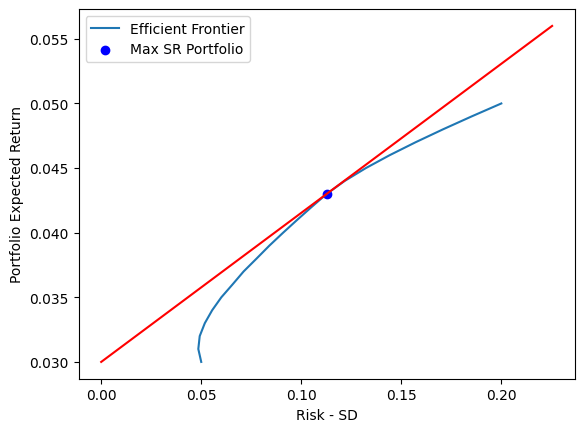

Portfolio Weights at the Maximum Sharpe Ratio: [0.3 0.7 0. ]
Portfolio Return : 0.04300000000000001
Portfolio Risk   : 0.11269427669584652
Portfolio SR     : 0.11535634622409482
Risk Parity Portfolio Weights: [0.15236386 0.23798327 0.60965287]
Risk Parity Portfolio Risk   : 0.062247719983597176
Risk Parity Portfolio Return : 0.03542710986236194
Risk Parity Portfolio SR     : 0.08718568107863275


In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Sample data
corr = np.array([[1, 0.5, 0],
                 [0.5, 1, 0.5],
                 [0, 0.5, 1]])
sd = np.array([0.2, 0.1, 0.05])
er = np.array([0.05, 0.04, 0.03])

# Calculate covariance matrix
covar = np.diag(sd) @ corr @ np.diag(sd)

def optimize_risk(R, er, covar):
    n = len(er)

    def objective(w):
        return w.T @ covar @ w

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: w @ er - R}
    ]
    bounds = [(0, 1) for _ in range(n)]
    init_guess = np.array([1/n] * n)
    result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return {'risk': result.fun, 'weights': result.x, 'R': R}

# Construct efficient frontier
returns = np.arange(0.03, 0.051, 0.001)
optim_portfolios = pd.DataFrame([optimize_risk(R, er, covar) for R in returns])

# Calculate Sharpe Ratios and find Max SR
rf = 0.03
optim_portfolios['SR'] = (optim_portfolios['R'] - rf) / np.sqrt(optim_portfolios['risk'])
maxSR_idx = optim_portfolios['SR'].idxmax()
maxSR_info = optim_portfolios.iloc[maxSR_idx]

# Plot Efficient Frontier
plt.plot(np.sqrt(optim_portfolios['risk']), optim_portfolios['R'], label='Efficient Frontier')
plt.xlabel('Risk - SD')
plt.ylabel('Portfolio Expected Return')

# Add line and scatter plot for Max SR Portfolio
w = np.arange(0, 2.1, 0.1)
returns_line = maxSR_info['R'] * w + rf * (1 - w)
risks_line = np.sqrt(maxSR_info['risk']) * w
plt.plot(risks_line, returns_line, label="", color="red")
plt.scatter([np.sqrt(maxSR_info['risk'])], [maxSR_info['R']], label="Max SR Portfolio", color="blue")

plt.legend(loc="upper left")
plt.show()

# Print Max SR Portfolio details
print(f"Portfolio Weights at the Maximum Sharpe Ratio: {maxSR_info['weights']}")
print(f"Portfolio Return : {maxSR_info['R']}")
print(f"Portfolio Risk   : {np.sqrt(maxSR_info['risk'])}")
print(f"Portfolio SR     : {maxSR_info['SR']}")


def optimize_risk_parity(covar):
    n = len(covar)

    def objective(w):
        portfolio_variance = np.dot(w, np.dot(covar, w))
        individual_risk_contributions = w * np.dot(covar, w) / portfolio_variance
        return np.sum((individual_risk_contributions - 1/n)**2)

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(n)]
    init_guess = np.array([1/n] * n)
    result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return {'weights': result.x, 'risk': np.dot(result.x, np.dot(covar, result.x))}

risk_parity_portfolio = optimize_risk_parity(covar)


# ... [existing code for Maximum SR Portfolio] ...

# Print Risk Parity Portfolio details
print(f"Risk Parity Portfolio Weights: {risk_parity_portfolio['weights']}")
print(f"Risk Parity Portfolio Risk   : {np.sqrt(risk_parity_portfolio['risk'])}")

# Calculate expected return and Sharpe Ratio for Risk Parity Portfolio
rp_er = np.dot(risk_parity_portfolio['weights'], er)
rp_sr = (rp_er - rf) / np.sqrt(risk_parity_portfolio['risk'])
print(f"Risk Parity Portfolio Return : {rp_er}")
print(f"Risk Parity Portfolio SR     : {rp_sr}")


In [205]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Reading covariance data
covar_df = pd.read_csv('problem3_cov.csv')
covar = covar_df.to_numpy()
print(covar)

# Reading expected return data
er_df = pd.read_csv('problem3_ER.csv')
rf = er_df['RF'][0]
# print(rf)
er = er_df.drop(columns=['RF']).to_numpy().flatten()
# print(er)


[[0.04938377 0.02974029 0.04020556]
 [0.02974029 0.03020819 0.03144534]
 [0.04020556 0.03144534 0.05520859]]


Notes
- The sr function is modified to return the negative of the Sharpe Ratio because the minimize function in SciPy performs minimization, and we want to maximize the Sharpe Ratio.
- The pvol, pCSD, and sseCSD functions are translated directly from the Julia code.
- The optimization problems use SciPy's minimize function with Sequential Least Squares Programming (SLSQP) method.
- Ensure that the CSV files are correctly read and that their paths are accurate.
- This code assumes that the covariance and expected return data are formatted similarly to how they were used in the Julia code.

In [206]:
# The sr function is modified to return the negative of the Sharpe Ratio because the minimize function in SciPy performs minimization, 
# and we want to maximize the Sharpe Ratio.
# Sharpe Ratio Function
def sr(w, er, covar, rf):
    m = np.dot(w, er) - rf
    s = np.sqrt(np.dot(w, np.dot(covar, w)))
    return -m/s  # Negative for minimization

# Portfolio Volatility Function
def pvol(w, covar):
    return np.sqrt(np.dot(w, np.dot(covar, w)))

# Component Standard Deviation Function
def pCSD(w, covar):
    p_vol = pvol(w, covar)
    csd = w * np.dot(covar, w) / p_vol
    return csd

# Sum Square Error of Component Standard Deviation
def sseCSD(w, covar):
    csd = pCSD(w, covar)
    mCSD = np.mean(csd)
    dCsd = csd - mCSD
    return 1.0e5 * np.sum(dCsd**2)


In [209]:
# Constraints and bounds
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, np.inf)] * len(er)
initial_guess = np.array([1/len(er)] * len(er))

# The optimization problems use SciPy's minimize function with Sequential Least Squares Programming (SLSQP) method.

# Optimization for Maximum SR
result_sr = minimize(sr, initial_guess, args=(er, covar, rf), bounds=bounds, constraints=cons)
wSR = np.round(result_sr.x, 4)

print("Max SR Weights:", wSR)


Max SR Weights: [0.3144 0.3961 0.2895]


In [208]:
# Optimization for Risk Parity
result_rp = minimize(sseCSD, initial_guess, args=(covar,), method='SLSQP', bounds=bounds, constraints=cons)
wRP = np.round(result_rp.x, 4)

print("Risk Parity Weights:", wRP)


Risk Parity Weights: [0.3101 0.3965 0.2933]


In the comparison of Maximum Sharpe Ratio (SR) and Risk Parity portfolios using the same dataset for covariance and expected returns, the observed weights ([0.3144, 0.3961, 0.2895] for Max SR and [0.3101, 0.3965, 0.2933] for Risk Parity) are strikingly similar, which is somewhat atypical for these distinct strategies. This similarity suggests that the assets in the dataset likely have closely aligned risk-return profiles, leading both strategies to converge towards similar allocations. While the Maximum SR strategy aims to maximize returns per unit of risk, typically favoring assets with higher risk-adjusted returns, and the Risk Parity approach focuses on equalizing risk contribution across assets, the minor differences in weights imply a subtle rebalancing in the Risk Parity strategy to achieve equal risk contribution. However, the closeness in the allocation indicates that the assets' characteristics, in terms of volatility, correlation, and expected returns, are such that both maximizing Sharpe Ratio and achieving risk parity lead to almost identical portfolio compositions. This convergence is indicative of a balanced risk-return trade-off within the selected assets, which is an intriguing scenario and might not be as pronounced with a different set of assets or under varying market conditions.

Problem 4

- Data in “problem4_returns.csv” is a series of returns for 3 assets. “problem4_startWeight.csv” is the starting weights of a portfolio of these assets as of the first day in the return series.

a. Calculate the new weights for the start of each time period (2pt)

b. Calculate the ex-post return attribution of the portfolio on each asset (4pt)

c. Calculate the ex-post risk attribution of the portfolio on each asset (2pt)

Using spring 2022 final exam data, ex-post return attribution of the portfolio of each asset is calculated below:

In [10]:
import pandas as pd
import numpy as np

# Reading the data
upReturns = pd.read_csv("/Users/ahmedibrahim/Desktop/Mids/Fall24/Quantitative Risk Management/exam prep/FinTech545/OldFinals/Spring2022/question10.csv")

# Initial Weights and Parameters
w = np.array([0.55, 0.27, 0.18])
stocks = ['A', 'B', 'C']
n = len(upReturns)
m = len(stocks)

pReturn = np.zeros(n)
weights = np.zeros((n, len(w)))
lastW = np.copy(w)
matReturns = upReturns[stocks].values

# Calculate portfolio return and updated weights for each day
for i in range(n):
    # Update Weights by return
    lastW = lastW * (1.0 + matReturns[i, :])
    
    # Portfolio return is the sum of the updated weights
    pR = np.sum(lastW)
    
    # Normalize the weights back so sum = 1
    lastW = lastW / pR
    
    # Store the return
    pReturn[i] = pR - 1
    weights[i, :] = lastW

# Set the portfolio return in the Update Return DataFrame
upReturns['Portfolio'] = pReturn

# Calculate the total return
totalRet = np.exp(np.sum(np.log(pReturn + 1))) - 1

# Calculate the Carino K
k = np.log(totalRet + 1) / totalRet

# Carino k_t is the ratio scaled by 1/K 
carinoK = np.log(1.0 + pReturn) / pReturn / k

# Calculate the return attribution
attrib = pd.DataFrame(matReturns * weights * carinoK[:, np.newaxis], columns=stocks)

# Set up a DataFrame for output
Attribution = pd.DataFrame(columns=['Value'] + stocks + ['Portfolio'])
Attribution['Value'] = ["TotalReturn", "Return Attribution"]

# Loop over the stocks
for s in stocks + ['Portfolio']:
    tr = np.exp(np.sum(np.log(upReturns[s] + 1))) - 1
    atr = tr if s == 'Portfolio' else np.sum(attrib[s])
    Attribution[s] = [tr, atr]

print(Attribution)


                Value         A         B         C  Portfolio
0         TotalReturn  0.053001 -0.089135  0.182844   0.037996
1  Return Attribution  0.027999 -0.021996  0.045425   0.037996


In [210]:
# import pandas as pd

# Read the returns and starting weights data
returns_df = pd.read_csv('problem4_returns.csv')
#drop the date column from returns
returns_df = returns_df.drop('Date', axis=1)
start_weights_df = pd.read_csv('problem4_startWeight.csv')

# Convert DataFrames to numpy arrays for calculations
returns = returns_df.to_numpy()
# print(returns.shape)
start_weights = start_weights_df.to_numpy().flatten()  # Assuming single row for start weights
# start_weights


In [211]:
n_days = len(returns)
n_assets = len(start_weights)
new_weights = np.zeros((n_days, n_assets))

# Initial weights
current_weights = start_weights.copy()

for i in range(n_days):
    # Update weights by returns
    current_weights *= (1 + returns[i])
    # Normalize to ensure weights sum to 1
    current_weights /= np.sum(current_weights)
    new_weights[i] = current_weights


In [212]:
#Calculate Ex-Post Return Attribution
return_attribution = returns * new_weights
print(return_attribution)

[[-1.74171652e-02  4.92576168e-03 -6.17399126e-03]
 [-3.05325274e-02  1.85874267e-02 -9.41808602e-05]
 [-2.88836333e-02 -4.93497480e-02 -5.18728474e-03]
 [-3.37702323e-02  5.36337521e-02 -8.47222948e-03]
 [-1.01939010e-02 -2.73426708e-02 -1.83474615e-03]
 [ 2.29762390e-02  8.81046032e-04 -3.99816954e-03]
 [ 4.35262505e-02 -4.00695665e-03  3.98596192e-03]
 [ 3.95574579e-03 -4.05881151e-03  3.62308715e-03]
 [-2.26540753e-03  2.75633741e-02  9.05860580e-03]
 [ 9.59603805e-03  3.97342704e-02 -8.92225544e-03]
 [ 4.18164792e-03  6.13494818e-03  1.25462738e-02]
 [ 4.09804153e-02  2.74883167e-02  1.69946852e-02]
 [-3.64265326e-02  9.96590445e-03 -2.19121491e-03]
 [-2.51212140e-02 -3.54520797e-02  2.58027738e-03]
 [ 3.11317808e-02  4.82999046e-02  1.85621774e-04]
 [-2.15282876e-02  5.79544380e-02  1.50115091e-03]
 [-1.14605924e-02 -2.04578362e-02  5.51000983e-03]
 [-1.35215117e-02  8.75583334e-03 -6.55306104e-03]
 [ 1.08042227e-02  8.00310247e-02 -4.42960041e-03]
 [-2.82745609e-04  4.54688212e-

In [213]:
# Assuming risk is measured as standard deviation of returns
risk_attribution = np.std(return_attribution, axis=0)
print(risk_attribution)

[0.0236237  0.032742   0.00692421]


In [214]:
print("New Weights for Each Time Period:")
print(new_weights)

print("Ex-Post Return Attribution for Each Asset:")
print(return_attribution.sum(axis=0))

print("Ex-Post Risk Attribution for Each Asset:")
print(risk_attribution)


New Weights for Each Time Period:
[[0.34210284 0.5480893  0.10980786]
 [0.31372246 0.57481651 0.11146103]
 [0.31051111 0.57328407 0.11620482]
 [0.27144457 0.62173909 0.10681634]
 [0.27200032 0.61866311 0.10933657]
 [0.28838474 0.60840618 0.10320908]
 [0.31566213 0.58121875 0.10311912]
 [0.31852034 0.57519958 0.10628008]
 [0.30591389 0.58287454 0.11121157]
 [0.30397675 0.59872067 0.09730259]
 [0.30159007 0.59196818 0.10644175]
 [0.31454645 0.57246255 0.11299099]
 [0.2835158  0.60185979 0.11462441]
 [0.27366112 0.60198787 0.124351  ]
 [0.28173533 0.60279804 0.11546663]
 [0.24942763 0.63720858 0.11336379]
 [0.2443604  0.6338422  0.1217974 ]
 [0.23309951 0.65050531 0.11639518]
 [0.22541595 0.67180285 0.1027812 ]
 [0.21747357 0.69164014 0.09088629]]
Ex-Post Return Attribution for Each Asset:
[-0.06425141  0.28875672  0.00043746]
Ex-Post Risk Attribution for Each Asset:
[0.0236237  0.032742   0.00692421]


New Q4

b. Calculate the ex-post return attribution of the portfolio on each asset (4pt)

In [216]:
returns_four = pd.read_csv('problem4_returns.csv', index_col='Date')
returns_four.index = pd.to_datetime(returns_four.index)

returns_four



,Asset1,Asset2,Asset3
Date,,,
2023-11-26,-0.050912,0.008987,-0.056225
2023-11-27,-0.097323,0.032336,-0.000845
2023-11-28,-0.093020,-0.086083,-0.044639
2023-11-29,-0.124409,0.086264,-0.079316
2023-11-30,-0.037478,-0.044196,-0.016781
2023-12-01,0.079672,0.001448,-0.038739
2023-12-02,0.137889,-0.006894,0.038654
2023-12-03,0.012419,-0.007056,0.034090
2023-12-04,-0.007405,0.047289,0.081454


In [217]:
# initial weights
start_weights = pd.read_csv('problem4_startWeight.csv').loc[0,:]
start_weights.index = returns_four.columns
start_weights.head()

Asset1    0.353383
Asset2    0.532550
Asset3    0.114067
Name: 0, dtype: float64

In [218]:
start_weights

Asset1    0.353383
Asset2    0.532550
Asset3    0.114067
Name: 0, dtype: float64

In [219]:
returns_four.iloc[0,:]+1

Asset1    0.949088
Asset2    1.008987
Asset3    0.943775
Name: 2023-11-26 00:00:00, dtype: float64

In [220]:
start_weights*returns_four.iloc[0,:]

Asset1   -0.017991
Asset2    0.004786
Asset3   -0.006413
dtype: float64

In [221]:
# Update the Weights
weights=[]
portfolio_rts=[]
for i in range(returns_four.shape[0]):
    # Store the weights
    weights.append(start_weights)
    # print(len(weights))
    # Update Weights by return
    start_weights=start_weights*(returns_four.iloc[i,:]+1) 
    # Calculate the portforlio return 
    p_rt=start_weights.sum()
# Normalize the wieghts back so sum = 1 
    start_weights=start_weights/p_rt
    # Store the portforlio return
    portfolio_rts.append(p_rt-1)
# print(len(weights))
# print(weights)
weights=pd.DataFrame(weights,index=returns_four.index)
weights.index=pd.to_datetime(weights.index)
print("--------------- New Weights ----------------")
weights
# print(portfolio_rts)

--------------- New Weights ----------------


,Asset1,Asset2,Asset3
Date,,,
2023-11-26,0.353383,0.532550,0.114067
2023-11-27,0.342103,0.548089,0.109808
2023-11-28,0.313722,0.574817,0.111461
2023-11-29,0.310511,0.573284,0.116205
2023-11-30,0.271445,0.621739,0.106816
2023-12-01,0.272000,0.618663,0.109337
2023-12-02,0.288385,0.608406,0.103209
2023-12-03,0.315662,0.581219,0.103119
2023-12-04,0.318520,0.575200,0.106280


In [107]:
weights.shape[1]

3

In [222]:
 # Add the Portfolio Return to the dataframe rts
returns_four['Portfolio Return'] = pd.DataFrame(portfolio_rts, index=returns_four.index)
# returns_four['Portfolio Return'] = returns_four['Portfolio Return'] + 1
# print(returns_four)
#calculate the total return
                
# print(returns_four['Portfolio Return'])
total_return = (returns_four['Portfolio Return']+1).prod() - 1

# print(total_return)

# Calculate the Carino K
k = np.log(total_return + 1) / total_return
# print(k)

# Carino k_t is the ratio scaled by 1/K
carinoK = np.log(1 + returns_four['Portfolio Return']) / k/ returns_four['Portfolio Return']
# print("--------------- Carino K ----------------")
# print(carinoK)

# type([carinoK])

# Transform carinoK to dataframe to be multiplied by weights and rts

carinoK_df = pd.DataFrame([carinoK]*weights.shape[1], index=weights.columns).T
# print("--------------- Carino K ----------------")
# print(carinoK_df)
# Calculate the return attribution (has been adjusted by carinoK_df)
return_attribution = (weights * carinoK_df * returns_four).dropna(axis=1)
# print("--------------- Return Attribution ----------------")
return_attribution
# Calculate the total return attribution

total_return_attribution = return_attribution.sum()
# print("--------------- Total Return Attribution ----------------")
# print(total_return_attribution)

# Combine the total_rt_attribution and total_rts together to compare with each other

attribution_df=pd.concat([total_return_attribution],axis=1).T
# print(attribution_df)
attribution_df.index=['TotalReturnAttribution']
attribution_df.loc['TotalReturnAttribution','PortfolioReturn']=attribution_df.loc['TotalReturnAttribution'][:-1].sum()
attribution_df




,Asset1,Asset2,Asset3,PortfolioReturn
TotalReturnAttribution,-0.104216,0.284254,-0.008093,0.180037


c. Calculate the ex-post risk attribution of the portfolio on each asset (2pt)

In [224]:
from scipy import linalg
# Y is stock returns scaled by their weight at each time
Y = (weights * returns_four).dropna(axis=1)

# Set up X with the Portfolio Return
X = pd.DataFrame(returns_four['Portfolio Return'])
X['Intersect']=1

# Calculate the Beta and discard the intercept
B = (linalg.inv(X.T@X)@X.T@Y).iloc[:-1,:]

# Component SD is Beta times the standard Deviation of the portfolio
cSD = B * returns_four['Portfolio Return'].std()

#Check that the sum of component SD is equal to the portfolio SD
print("Does the the sum of component SD is equal to the portfolio SD? {}".format(np.isclose(cSD.sum(axis=1),returns_four['Portfolio Return'].std())[0]))

# Add the portfolio SD to the cSD
cSD['Portfolio']=returns_four['Portfolio Return'].std()

# Add the Vol attribution to attribution_df
columns=list(attribution_df.columns)
columns[-1]='Portfolio'
Vol_attribution=pd.DataFrame(columns=columns)
Vol_attribution.loc['VolatilityAttribution',:]=cSD.values
Vol_attribution

Does the the sum of component SD is equal to the portfolio SD? True


,Asset1,Asset2,Asset3,Portfolio
VolatilityAttribution,0.018242,0.026251,0.001666,0.046159


problem 5

In [192]:
from scipy.stats import norm,spearmanr,multivariate_normal,t
prices_df=pd.read_csv('problem5.csv')
prices_df.head()


returns = return_calculate(prices_df, method="DISCRETE", date_column="Date")
# print(returns.head())
returns.columns = ['Date','Return1', 'Return2', 'Return3', 'Return4']
#make date the index column
returns = returns.set_index('Date')
print(returns)

             Return1   Return2   Return3   Return4
Date                                              
2023-10-17 -0.000292 -0.000496 -0.000443 -0.000393
2023-10-18  0.000178  0.000228  0.000212  0.000076
2023-10-19  0.000139  0.000160  0.000176  0.000188
2023-10-20  0.000077  0.000125  0.000161  0.000222
2023-10-21 -0.000384 -0.000585 -0.000505 -0.000700
2023-10-22  0.000393  0.000551  0.000463  0.000612
2023-10-23 -0.000101 -0.000012 -0.000167 -0.000071
2023-10-24  0.000107 -0.000004  0.000162  0.000086
2023-10-25 -0.000224 -0.000174 -0.000160 -0.000023
2023-10-26  0.000239  0.000351  0.000113  0.000031
2023-10-27 -0.000119 -0.000219 -0.000084 -0.000032
2023-10-28  0.000236  0.000249  0.000240  0.000204
2023-10-29 -0.000252 -0.000264 -0.000226 -0.000369
2023-10-30 -0.000006 -0.000043 -0.000056  0.000085
2023-10-31  0.000060  0.000129  0.000127  0.000037
2023-11-01 -0.000218 -0.000291 -0.000284 -0.000290
2023-11-02  0.000298  0.000340  0.000296  0.000275
2023-11-03  0.000052  0.000019 

In [193]:
Y = returns.copy()

# Use the CDF to transform the data to uniform universe
U=[]
Model_T=[]
for i in range(Y.shape[1]):
    params=t.fit(Y.iloc[:,i].values)
    Model_T.append(t(df=params[0],loc=params[1],scale=params[2]))
    U.append(Model_T[i].cdf(Y.iloc[:,i]))

nSim = 10000

# Gaussian Copula
# Use the standard normal quantile function to transform the uniform to normal 
Z=norm.ppf(U)
Z=pd.DataFrame(Z,index=Y.columns).T
# Spearman correlation
corr_spearman = spearmanr(Z,axis=0)[0]
# Simulate Normal & Transform to uniform
simU=norm.cdf(multivariate_normal.rvs(cov=corr_spearman, size=nSim))
simU=pd.DataFrame(simU,columns=Y.columns)
# Transform to T Distribution
simReturns=[]
for i in range(Y.shape[1]):
    simReturns.append(Model_T[i].ppf(simU.iloc[:,i]))

# convert simulated returns to dataframe
simReturns=pd.DataFrame(simReturns,index=Y.columns).T

### a. Calculate VaR (5%) for each asset (3pt)

In [197]:
def VaR_historical(data,alpha=0.05):
     
     '''Given a dataset(array), calculate the its historical VaR'''
     data.sort()
     n=round(data.shape[0]*alpha)
     return -data[n-1]

In [198]:
# Var1
VaR_1=VaR_historical(simReturns['Return1'].to_numpy(),alpha=0.05)*df_price.iloc[-1,:]['Price1']
print("The fisrt VaR is ${:.5f}".format(VaR_1))

# Var2
VaR_2=VaR_historical(simReturns['Return2'].to_numpy(),alpha=0.05)*df_price.iloc[-1,:]['Price2']
print("The second VaR is ${:.5f}".format(VaR_2))

# Var3
VaR_3=VaR_historical(simReturns['Return3'].to_numpy(),alpha=0.05)*df_price.iloc[-1,:]['Price3']
print("The third VaR is ${:.5f}".format(VaR_3))

# Var4
VaR_4=VaR_historical(simReturns['Return4'].to_numpy(),alpha=0.05)*df_price.iloc[-1,:]['Price4']
print("The forth VaR is ${:.5f}".format(VaR_4))

The fisrt VaR is $0.05073
The second VaR is $0.07142
The third VaR is $0.05398
The forth VaR is $0.05327
